In [73]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [74]:
def mean_absolute_percentage_error(real, predict):
    res = 0
    count = 0
    for i in range(len(real)):
        if real[i] != 0:
            res += abs((predict[i]-real[i])/real[i])
            count += 1
    return res/count

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    n_vars = 1 if type(data) is list else data.shape[1]

    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

(1106, 4)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1   0.000012   0.538462   0.000000   0.183087  0.343635
2   0.000012   0.487179   0.000000   0.343635  0.485551
3   0.000012   0.653846   0.000000   0.485551  0.530059
4   0.000006   0.525641   0.000000   0.530059  0.542535
5   0.000002   0.730769   0.012283   0.542535  0.535841
(1106, 1, 4) (1106,) (0, 1, 4) (0,)
1 4
Epoch 1/50
16/16 - 0s - loss: nan
Epoch 2/50
16/16 - 0s - loss: nan
Epoch 3/50
16/16 - 0s - loss: nan
Epoch 4/50
16/16 - 0s - loss: nan
Epoch 5/50
16/16 - 0s - loss: nan
Epoch 6/50
16/16 - 0s - loss: nan
Epoch 7/50
16/16 - 0s - loss: nan
Epoch 8/50
16/16 - 0s - loss: nan
Epoch 9/50
16/16 - 0s - loss: nan
Epoch 10/50
16/16 - 0s - loss: nan
Epoch 11/50
16/16 - 0s - loss: nan
Epoch 12/50
16/16 - 0s - loss: nan
Epoch 13/50
16/16 - 0s - loss: nan
Epoch 14/50
16/16 - 0s - loss: nan
Epoch 15/50
16/16 - 0s - loss: nan
Epoch 16/50
16/16 - 0s - loss: nan
Epoch 17/50
16/16 - 0s - loss: nan
Epoch 18/50
16/16 - 0s - los

KeyError: 'val_loss'

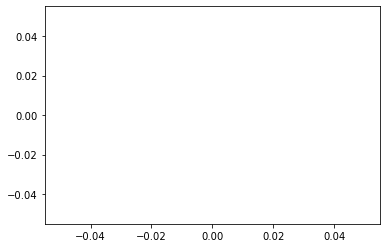

In [84]:
# load dataset
'''
header = 0: 排除第一行数据； header = -1: 包含第一行数据；
index_col=0：排除第一列数据；index_col=-1：包含第一列数据；
'''
dataset = read_csv('ele_pre.csv', header=0,index_col=0)
dataset.columns = ['high_tem', 'low_tem', 'avg_tem','com_him','rain','power']
values = dataset.values
values = values.astype('float32')
# dataset.head
values = np.delete(values,[0,1],axis=1)
print(values.shape)
# normalize features
# scaler = MinMaxScaler().fit(values)
# scaled = scaler.fit_transform(values)
# frame as supervised learning
# split into train and test sets
values = MinMaxScaler().fit_transform(values)  
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
print(reframed.head())

n_train_hours = 365 * 24 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# # split into input and outputs
train_X, train_y = train[:, :], train[:, -1]
test_X, test_y = test[:, :], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape[1],train_X.shape[2])
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(6,100)
        self.fc2 = nn.Linear(100,256)
        self.fc3 = nn.Linear(256,512)
        self.fc4 = nn.Linear(512,128)
        self.fc5 = nn.Linear(128,1)
        
    
    def forward(self,x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        return out

model = Model()
#setting
learing_rate = 0.05
epochs = 500
optimizer = torch.optim.Adam(model.parameters(),lr=learing_rate)
# optimizer = torch.optim.Adagrad(torch.nn.parameter(),lr=0.01)
criterion = nn.MSELoss()

In [ ]:
train_X = torch.from_numpy(train_X)
train_y =torch.from_numpy(train_y)
test_X = torch.from_numpy(test_X)
test_y= torch.from_numpy(test_y)

In [ ]:
for epoch in range(epochs):
    y_pred = model(train_X)
    y2_pred = y_pred.squeeze()
    loss = criterion(y2_pred,train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_dlr_pred = model(test_X)
        y3_pred = y_dlr_pred.squeeze()
        testloss = criterion(y3_pred,test_y)
    if(epoch+1)%50==0:
        print("loss: {:2f} test loss: {:2f}".format(loss.item(),testloss.item()))


# mape = mean_absolute_percentage_error(y3_pred, test_y)
# print('Test mape: %.3f' % mape)
